In [204]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from typing import Tuple
from tqdm import tqdm
from matplotlib import cm


# TD Learning

In [205]:
def add_stimulus(series: np.ndarray, t: int = 100, std: float = 0):
    # add a gaussian stimulus at time t and with distribution std
    if std != 0:
        raise NotImplementedError("Currently assuming only point mass stimulus")
    
    series[t] += 1
    return series


def add_reward(series: np.ndarray, t: int = 200, std: float = 2):
    x = np.arange(len(series))
    y = 1 / (std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x - t)**2 / std**2)
    return series + y


length = 300
stimulus = np.zeros(length)
stimulus = add_stimulus(stimulus)
reward = np.zeros(length)
reward = add_reward(reward)

In [217]:

def get_value(weights: np.ndarray, stimulus: np.ndarray) -> np.ndarray:
    v = np.zeros_like(weights)
    length = len(weights)
    for t in range(length):
        v[t] = np.dot(weights[:t], stimulus[1 : t + 1][::-1])
    return v


def get_delta(reward: np.ndarray, value: np.ndarray) -> np.ndarray:
    future_value = value[1:]
    current_value = value[:-1]
    delta = reward[:-1] + future_value - current_value
    return delta


def learn_step(weights: np.ndarray, stimulus: np.ndarray, delta: np.ndarray, epsilon: float) -> np.ndarray:
    length = len(weights)
    for t in range(length - 1):
        weights[:t] += epsilon * delta[t] * stimulus[1 : t + 1][::-1]
    return weights


def td_learning(stimulus: np.ndarray, reward: np.ndarray, epsilon: float = 0.98, n_trials: int = 100):
    if len(stimulus.shape) == 1:
        # stack it n_trials open 
        stimulus = stimulus[None].repeat(n_trials, axis=0)
    elif len(stimulus.shape) == 2:
        assert len(stimulus) == n_trials
    else:
        raise ValueError("stimulus has not the right shape")
    
    if len(reward.shape) == 1:
        # stack it n_trials open 
        reward = reward[None].repeat(n_trials, axis=0)
    elif len(reward.shape) == 2:
        assert len(reward) == n_trials
    else:
        raise ValueError("reward has not the right shape")
    
    
    weights = np.zeros(stimulus.shape[1])
    history = {
        "value": [],
        "weights": [],
        "deltas": [],
    }
    for epoch_idx in tqdm(range(n_trials)):
        value = get_value(weights, stimulus[epoch_idx])
        deltas = get_delta(reward[epoch_idx], value)
        weights = learn_step(weights, stimulus[epoch_idx], deltas, epsilon)

        history["deltas"].append(deltas)
        history["value"].append(value)
        history["weights"].append(weights)

    for key in history.keys():
        history[key] = np.stack(history[key])
    return history

epsilon = 0.8
n_trials = 200
history = td_learning(stimulus, reward, n_trials=n_trials, epsilon=epsilon)

100%|██████████| 200/200 [00:00<00:00, 460.27it/s]


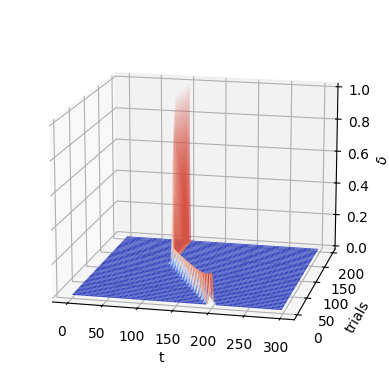

In [220]:
def plot_suface(z: np.ndarray, label: str = ""):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Make data.
    X = np.arange(z.shape[1])
    Y = np.arange(z.shape[0])
    X, Y = np.meshgrid(X, Y)

    # Plot the surface.
    ax.view_init(15, -77, 0)
    surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm) # antialiased=True)
    ax.set_xlabel("t")
    ax.set_ylabel("trials")
    ax.set_zlabel(label)

plot_suface(history["deltas"], label=r"$\delta$")


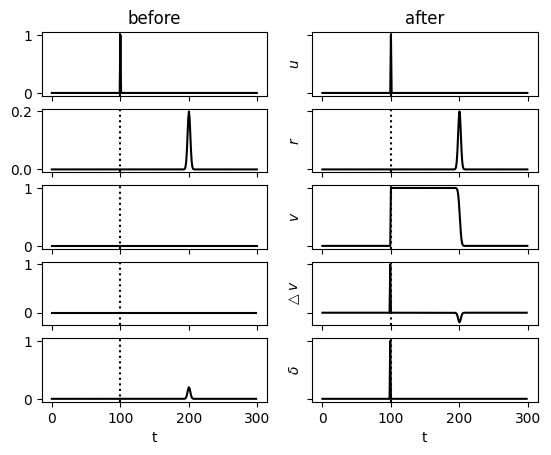

In [221]:
def plot_comparison(stimulus, reward, history):
    fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey="row")
    axes[0, 0].set_title("before")
    axes[0, 1].set_title("after")
    axes[0, 1].set_ylabel(r"$u$")
    axes[1, 1].set_ylabel(r"$r$")
    axes[2, 1].set_ylabel(r"$v$")
    axes[3, 1].set_ylabel(r"$\triangle v$")
    axes[4, 1].set_ylabel(r"$\delta$")

    axes[0, 0].plot(stimulus, c="k")
    axes[0, 1].plot(stimulus, c="k")

    axes[1, 0].plot(reward, c="k")
    axes[1, 1].plot(reward, c="k")

    axes[2, 0].plot(history["value"][0], c="k")
    axes[2, 1].plot(history["value"][-1], c="k")

    axes[3, 0].plot(np.diff(history["value"][0]), c="k")
    axes[3, 1].plot(np.diff(history["value"][-1]), c="k")

    axes[4, 0].plot(history["deltas"][0], c="k")
    axes[4, 1].plot(history["deltas"][-1], c="k")

    axes[4, 0].set_xlabel("t")
    axes[4, 1].set_xlabel("t")

    for ax in axes.flatten():
        ax.axvline(100, color="k", linestyle="dotted")

plot_comparison(stimulus, reward, history)


100%|██████████| 200/200 [00:00<00:00, 462.11it/s]


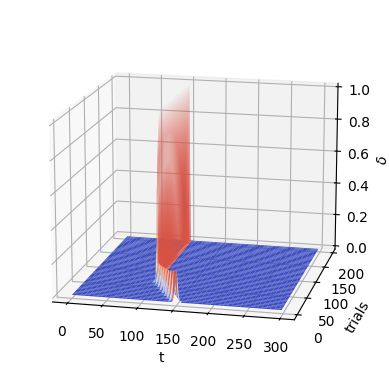

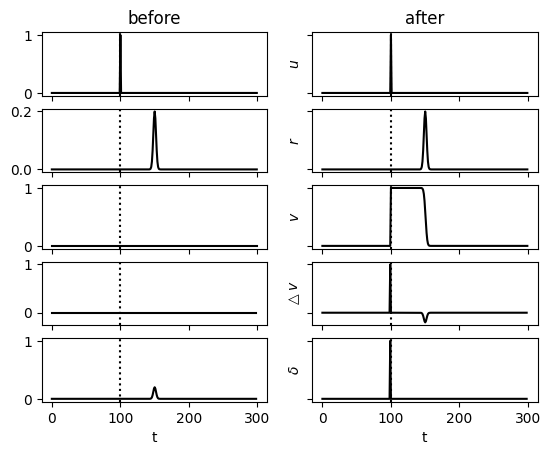

In [224]:
stimulus = np.zeros(length)
stimulus[100] = 1
reward = np.zeros(length)
reward = add_reward(reward, 150)

history = td_learning(stimulus, reward, epsilon, n_trials)
plot_suface(history["deltas"], label=r"$\delta$")
plot_comparison(stimulus, reward, history)

100%|██████████| 200/200 [00:00<00:00, 487.77it/s]


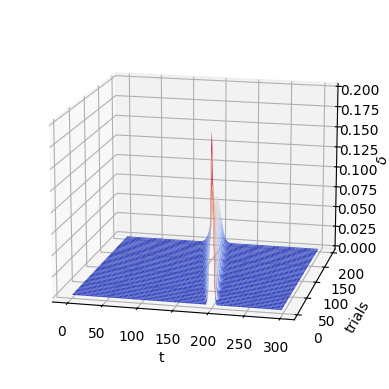

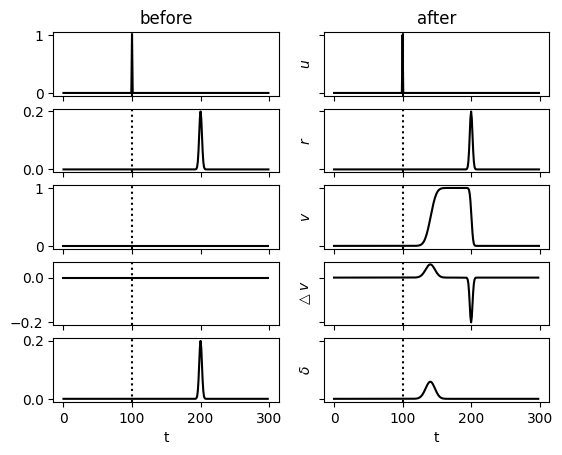

In [227]:
stimulus = np.zeros(length)
stimulus[100] = 1
reward = np.zeros(length)
reward = add_reward(reward, 200)

history = td_learning(stimulus, reward, 0.3, n_trials)
plot_suface(history["deltas"], label=r"$\delta$")
plot_comparison(stimulus, reward, history)

100%|██████████| 200/200 [00:00<00:00, 513.02it/s]


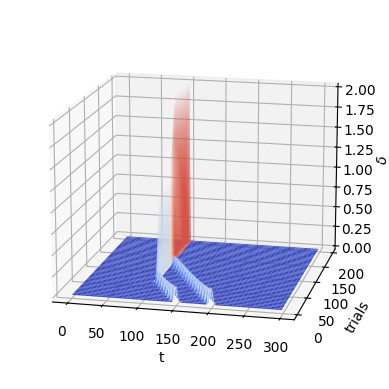

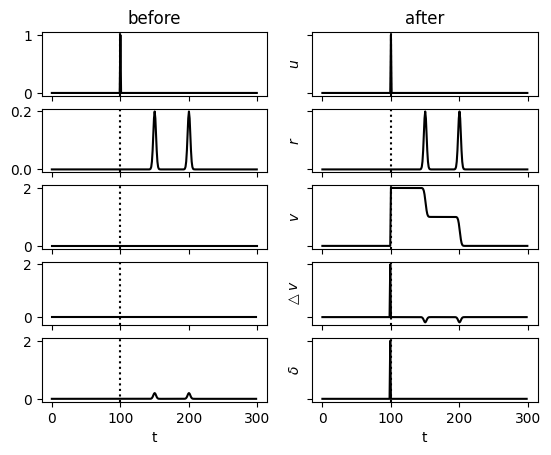

In [228]:
stimulus = np.zeros(length)
stimulus[100] = 1
reward = np.zeros(length)
reward = add_reward(reward, 150)
reward = add_reward(reward, 200)

history = td_learning(stimulus, reward, epsilon, n_trials)
plot_suface(history["deltas"], label=r"$\delta$")
plot_comparison(stimulus, reward, history)

100%|██████████| 200/200 [00:00<00:00, 487.36it/s]


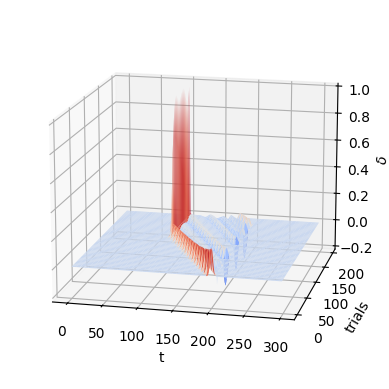

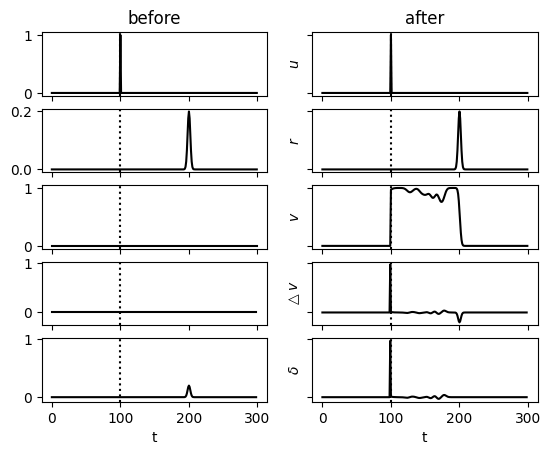

In [236]:
stimulus = np.zeros(length)
stimulus[100] = 1
reward = np.zeros(length)
reward = add_reward(reward, 200)
binary_mask = np.random.binomial(1, 0.9, n_trials)
random_reward = reward[None] * binary_mask[:, None]

history = td_learning(stimulus, random_reward, epsilon, n_trials)
plot_suface(history["deltas"], label=r"$\delta$")
plot_comparison(stimulus, reward, history)

# Successor Learning

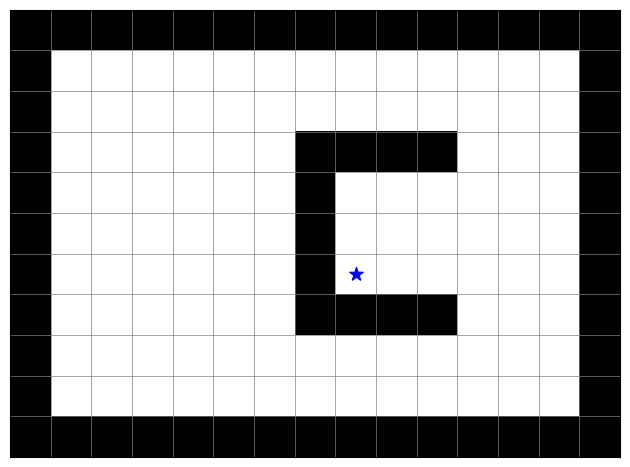

In [148]:
# define maze

maze = np.zeros((9, 13))

# place walls
maze[2, 6:10] = 1
maze[-3, 6:10] = 1
maze[2:-3, 6] = 1

# define start
start = (6, 8)

# pad maze
pad = np.ones(np.array(maze.shape) + 2)
pad[1:-1, 1:-1] = maze
maze = pad

def plot_maze(maze) -> Tuple[Figure, Axes]:
    fig, ax = plt.subplots()
    ax.imshow(maze, cmap='binary')

    # draw thin grid
    for i in range(maze.shape[0]):
        ax.plot([-0.5, maze.shape[1]-0.5], [i-0.5, i-0.5], c='gray', lw=0.5)
    for i in range(maze.shape[1]):
        ax.plot([i-0.5, i-0.5], [-0.5, maze.shape[0]-0.5], c='gray', lw=0.5)

    ax.set_xticks([])
    ax.set_yticks([])

    return fig, ax

plot_maze(maze)
plt.scatter(start[1], start[0], marker='*', color='blue', s=100)
plt.tight_layout()
# plt.savefig('maze.png')
plt.show()

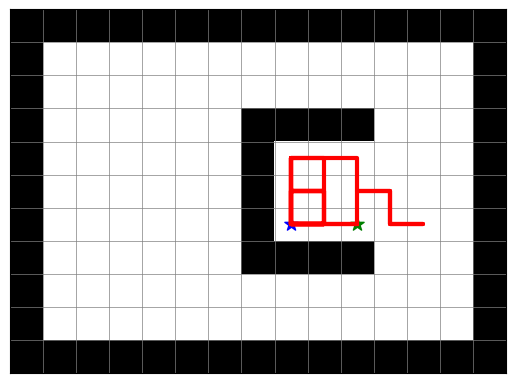

In [149]:
def random_walk(maze, start, n_steps):
    # perform a single random walk in the given maze, starting from start, performing n_steps random moves
    # moves into the wall and out of the maze boundary are not possible

    # initialize list to store positions
    
    positions = np.empty((n_steps + 1, len(maze.shape)), dtype=int)
    positions[0] = start

    # perform random steps...
    possible_moves = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]], dtype=int)    
    for i in range(n_steps):
        move_options = positions[i][None] + possible_moves
        # remove those moves which run into a barrier
        move_options = 1 - maze[*move_options.T]
        # int prob distribution
        p = move_options / move_options.sum()
        move_idx = np.random.choice(len(possible_moves), p=p)
        move = possible_moves[move_idx]
        positions[i+1] = positions[i] + move
        
    # return a list of length n_steps + 1, containing the starting position and all subsequent locations as e.g. tuples or size (2) arrays 
    return positions

def plot_path(maze, path):
    # plot a maze and a path in it
    plot_maze(maze)
    path = np.array(path)
    plt.plot(path[:, 1], path[:, 0], c='red', lw=3)
    plt.scatter(path[0, 1], path[0, 0], marker='*', color='blue', s=100)
    plt.scatter(path[-1, 1], path[-1, 0], marker='*', color='green', s=100)
    plt.show()

# plot a random path
path = random_walk(maze, start, 40)
plot_path(maze, path)

  0%|          | 0/5001 [00:00<?, ?it/s]

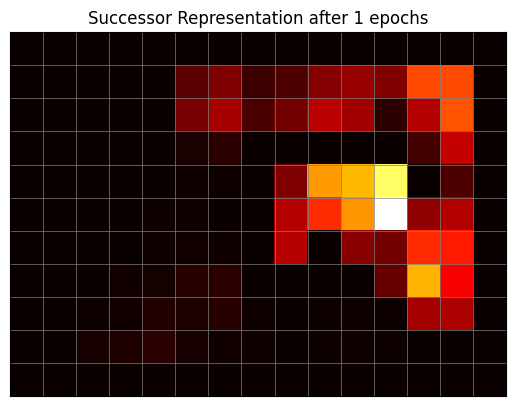

  0%|          | 6/5001 [00:00<01:27, 57.17it/s]

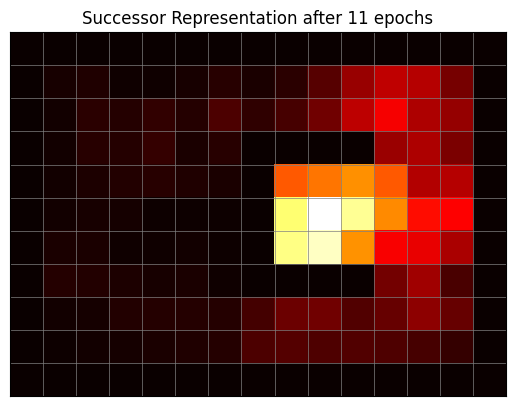

  2%|▏         | 92/5001 [00:00<00:40, 121.90it/s]

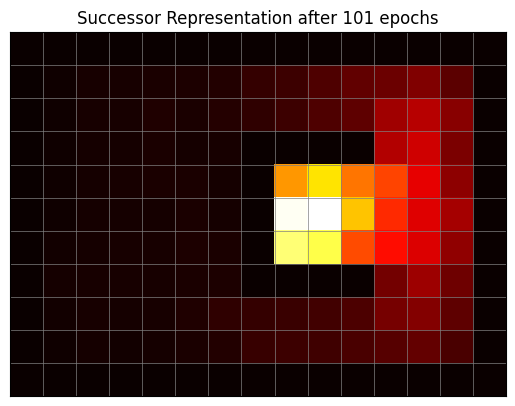

 20%|█▉        | 988/5001 [00:08<00:32, 121.72it/s]

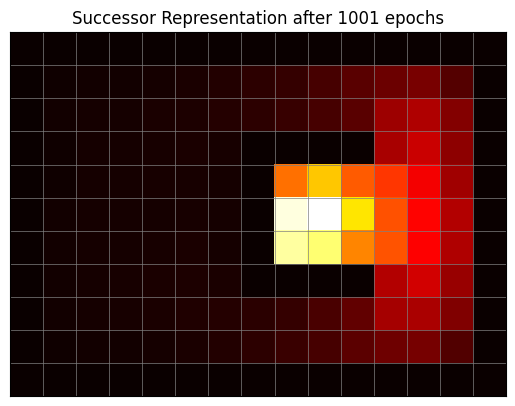

100%|█████████▉| 4997/5001 [00:38<00:00, 123.82it/s]

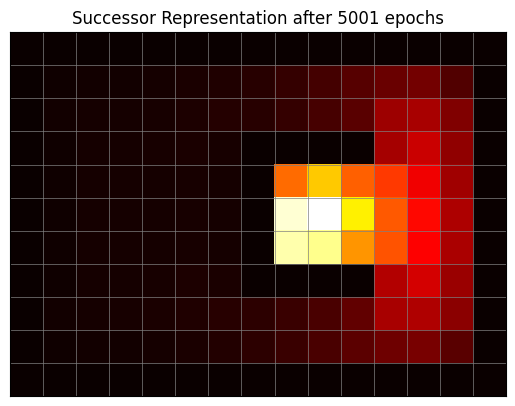

100%|██████████| 5001/5001 [00:39<00:00, 128.17it/s]


In [150]:
def learn_from_traj(succ_repr, trajectory, gamma=0.98, alpha=0.02):
    # Write a function to update a given successor representation (for the state at which the trajectory starts) using an example trajectory
    # using discount factor gamma and learning rate alpha
    
    discount = 1
    for point in trajectory:
        succ_repr[*point] += discount
        discount *= gamma

    # return the updated successor representation
    return succ_repr

# initialize successor representation
succ_repr = np.zeros_like(maze)

# sample a whole bunch of trajectories (reduce this number if this code takes too long, but it shouldn't take longer than a minute with reasonable code)
for i in tqdm(range(5001)):
    # sample a path (we use 340 steps here to sample states until the discounting becomes very small)
    path = random_walk(maze, start, 340)
    # update the successor representation
    succ_repr = learn_from_traj(succ_repr, path, alpha=0.02)  # choose a small learning rate
    
    # occasionally plot it
    if i in [0, 10, 100, 1000, 5000]:
        fig, ax = plot_maze(maze)
        ax.set_title(f"Successor Representation after {i + 1} epochs")
        # succ_repr[maze.astype(bool)] = np.nan
        ax.imshow(succ_repr, cmap='hot')
        # if i == 5000:
        #     plt.savefig("empirical")
        plt.show()
        

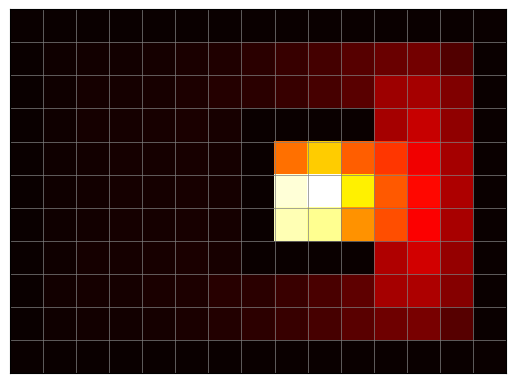

In [151]:
def compute_transition_matrix(maze: np.ndarray) -> np.ndarray:
    # for a given maze, compute the transition matrix from any state to any other state under a random walk policy
    # (you will need to think of a good way to map any 2D grid coordinates onto a single number for this)

    # create a matrix over all state pairs
    n_states = len(maze.flatten())
    transitions = np.zeros((n_states, n_states))

    indices = np.arange(n_states).reshape(maze.shape)
    
    # only vertical or horizontal moves allowed
    possible_moves = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]], dtype=int)
    
    # allow diagonal moves
    # possible_moves = np.array([[-1, 0], [1, 0], [0, -1], [0, 1], [1, 1], [1, -1], [-1, 1], [-1, -1]], dtype=int)

    # iterate over all states, filling in the transition probabilities to all other states on the next step (only one step into the future)
    for state_idx, (i, j) in enumerate(
        product(range(maze.shape[0]), range(maze.shape[1]))
    ):
        cell = maze[i, j]
        if cell == 1:
            continue

        coords = np.array([i, j])
        move_options = coords + possible_moves
        future_cell_values = maze[*move_options.T]
        move_options = move_options[~future_cell_values.astype(bool)]
        future_states = indices[*move_options.T]
        # print(coords, future_states)
        transitions[state_idx, future_states] += 1
        # normalize transitions if necessary
        transitions[state_idx] /= transitions[state_idx].sum()

    return transitions


transitions = compute_transition_matrix(maze)
n_states = len(transitions)

one_hot_start = np.zeros(n_states)
one_hot_start[start[0] * maze.shape[1] + start[1]] = 1

indices = np.arange(n_states).reshape(maze.shape)


succ_repr = np.zeros(n_states)
tx = np.eye(n_states)
gamma = 0.98
for i in range(340):
    succ_repr += tx.T @ one_hot_start
    tx = gamma * tx @ transitions

fig, ax = plot_maze(maze)
ax.imshow(succ_repr.reshape(maze.shape), cmap="hot")
# ax.imshow((tx.T @ one_hot_start).reshape(maze.shape), alpha=0.8, cmap="hot")

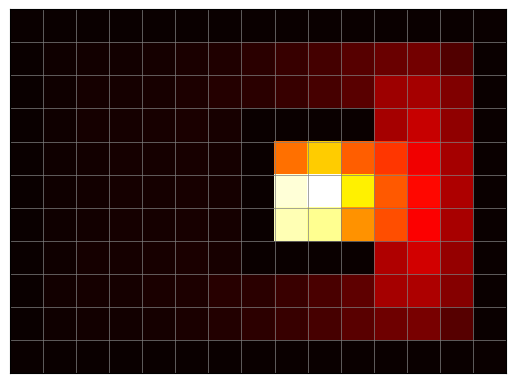

In [152]:
def compute_sr(transitions, i, j, maze, gamma=0.98):
    """
    given a transition matrix and a specific state (i, j).
    compute the successor representation of that state with discount factor gamma
    """

    # initialize things (better to represent the current discounted occupancy as a vector here)
    n_states = len(transitions)
    current_discounted_occupancy = np.zeros(n_states)
    total = current_discounted_occupancy.copy()

    one_hot_start = np.zeros(n_states)
    one_hot_start[i * maze.shape[1] + j] = 1

    # iterate for a number of steps
    tx = np.eye(n_states)
    for _ in range(340):
        current_discounted_occupancy = tx.T @ one_hot_start
        total += current_discounted_occupancy
        tx = gamma * tx @ transitions

    # return the successor representation, maybe reshape your vector into the maze shape now
    return total.reshape(maze.shape)


sr = compute_sr(transitions, *start, maze)
fig, ax = plot_maze(maze)
ax.imshow(sr, cmap="hot")
